In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score

from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv('/content/drive/My Drive/Mushroom_competition_data/7.4.3.1_mushroom_competition_train_data.csv')
test_df = pd.read_csv('/content/drive/My Drive/Mushroom_competition_data/7.4.3.2_mushroom_competition_test_data.csv')

Mounted at /content/drive


In [2]:

X = train_df.drop(['Id', 'poisonous'], axis=1)
y = train_df['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6499, 6), (6499,), (5199, 6), (1300, 6), (5199,), (1300,))

In [3]:
pipe = make_pipeline(
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
    RandomForestClassifier(n_estimators=500, random_state=123)
)

In [4]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500, random_state=123))])

In [5]:
pipe.predict(X_test)

array([1, 0, 0, ..., 1, 1, 1])

In [6]:
accuracy_score(y_true=y_test, y_pred=pipe.predict(X_test))

0.9661538461538461

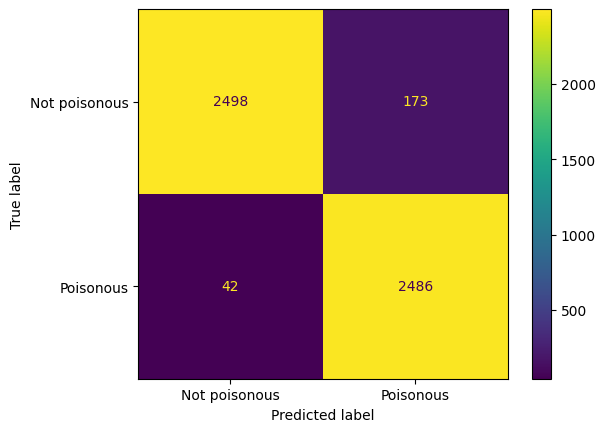

In [7]:
ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

Recall Score: 1.0


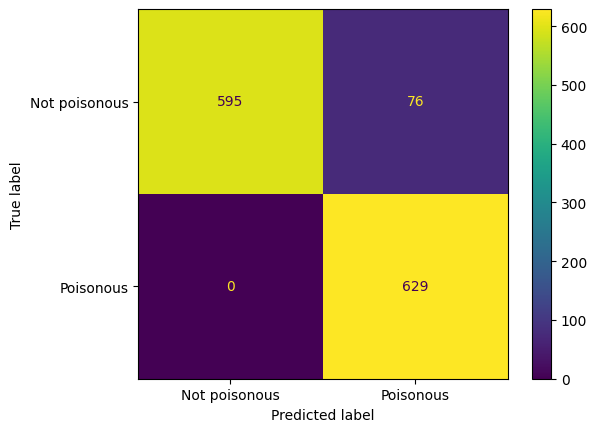

In [8]:
param_grid = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth': [10],
    'randomforestclassifier__class_weight': [{0: 1, 1: 5}]  # <<< class weights
}

grid_search = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Predict using best_model
y_pred = best_model.predict(X_test)

# Calculate Recall score
recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=["Not poisonous", "Poisonous"]);



In [9]:
feature_cols = X_train.columns

test_data_for_prediction = test_df[feature_cols]

test_predictions = best_model.predict(test_data_for_prediction)

submission_df = pd.DataFrame({'Id': test_df['Id'], 'poisonous': test_predictions})

submission_df.to_csv('mushroom.csv', index=False)